In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import math
import json
import os
import wandb
from datasets import get_real_dataset
from utils import hash_dict, signal_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sns.set_palette("colorblind")

In [133]:
project_path = "whfourier/SGEMMEarly"
dataset_name = "SGEMM"

criteria = {
    "fix_seed": [1, 2, 3, 4, 5],
    # "fix_seed": [1, 2, 3],
    "random_seed": [11, 22, 33, 44, 55],
    "lr": 0.01,
    "train_size": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    # "train_size": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    "training_method": ["normal", "hashing", "EN-S"]
}

dataset = get_real_dataset(dataset_name)

Loaded dataset from cache.


## Size-R2 plot

200 normal 15
200 hashing 180
200 EN-S 30
400 normal 15
400 hashing 180
400 EN-S 30
600 normal 15
600 hashing 180
600 EN-S 30
800 normal 15
800 hashing 180
800 EN-S 30
1000 normal 15
1000 hashing 180
1000 EN-S 30
1200 normal 15
1200 hashing 180
1200 EN-S 30
1400 normal 15
1400 hashing 180
1400 EN-S 30
1600 normal 15
1600 hashing 180
1600 EN-S 30
1800 normal 15
1800 hashing 180
1800 EN-S 30
2000 normal 15
2000 hashing 180
2000 EN-S 30


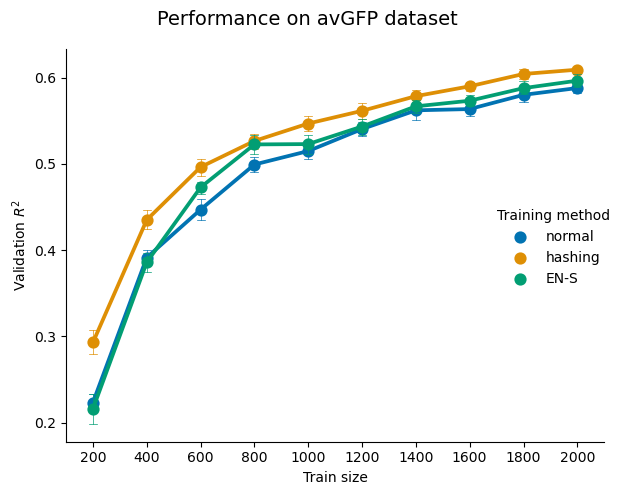

In [3]:
api = wandb.Api(timeout=60)

best_results = {} # train_size.training_method
for train_size in criteria["train_size"]:
    best_results_train_size = {}
    for training_method in criteria["training_method"]:
        filters = {f'config.{k}': v for k, v in criteria.items()}
        filters["config.training_method"] = training_method
        filters["config.train_size"] = train_size
        filters.pop("config.fix_seed", None)
        filters.pop("config.random_seed", None)
        runs = api.runs(project_path, filters=filters)
        print(train_size, training_method, len(runs))

        best_results_training_method = []
        for fix_seed in criteria["fix_seed"]:
            for random_seed in criteria["random_seed"]:
                best_model_idx = np.argmax([run.summary.get("max_val_r2", -math.inf) if run.config["fix_seed"]==fix_seed and run.config["random_seed"]==random_seed else -math.inf 
                                            for run in runs])
                best_results_training_method.append(runs[best_model_idx].summary["best_test_r2"])
            
        best_results_train_size[training_method] = best_results_training_method
    best_results[train_size] = best_results_train_size


results = {"Training method":[], "Train size": [], "Validation R2": []}
for train_size in criteria["train_size"]:
    for training_method in criteria["training_method"]:
        results["Training method"].extend([training_method] * len(best_results[train_size][training_method]))
        results["Train size"].extend([train_size] * len(best_results[train_size][training_method]))
        results["Validation R2"].extend(best_results[train_size][training_method])

g = sns.catplot(x="Train size", y="Validation R2", hue="Training method", kind="point", 
            capsize=.15, data=pd.DataFrame.from_dict(results), aspect=1, errwidth=0.5)
g.set_ylabels("Validation $R^2$")
g.fig.suptitle(f"Performance on {dataset_name} dataset", fontsize=14)
g.fig.tight_layout()


## Time-R2 plot

In [134]:
api = wandb.Api(timeout=60)
train_size = 1000

results = {"Training method":[], "Time": [], "Validation R2": []}
agg_results = {"Training method":[], "Time": [], "Time Error": [], "Validation R2": [], "Validation R2 Error": []}
best_results_train_size = {}
for training_method in criteria["training_method"]:
    filters = {f'config.{k}': v for k, v in criteria.items()}
    filters["config.training_method"] = training_method
    filters["config.train_size"] = train_size
    filters.pop("config.fix_seed", None)
    filters.pop("config.random_seed", None)
    runs = api.runs(project_path, filters=filters)
    print(train_size, training_method, len(runs))
    bs = set([run.config.get("b", -1) for run in runs])

    for b in bs:
        filtered_runs = [run for run in runs if run.config.get("b", -1)==b]
        best_models = []
        for fix_seed in criteria["fix_seed"]:
            for random_seed in criteria["random_seed"]:
                best_model_idx = np.argmax([run.summary.get("max_val_r2", -math.inf) if run.config["fix_seed"]==fix_seed and run.config["random_seed"]==random_seed else -math.inf 
                                            for run in filtered_runs])
                best_models.append(filtered_runs[best_model_idx])
                # Add to results
                results["Training method"].append(training_method)
                results["Time"].append(filtered_runs[best_model_idx].summary["_runtime"])
                results["Validation R2"].append(filtered_runs[best_model_idx].summary["best_test_r2"])
                
        times = [run.summary["_runtime"] for run in best_models]
        r2s = [run.summary["best_test_r2"] for run in best_models]
        # Add to aggregated results
        agg_results["Training method"].append(training_method)
        agg_results["Time"].append(np.mean(times))
        agg_results["Time Error"].append(np.std(times))
        agg_results["Validation R2"].append(np.mean(r2s))
        agg_results["Validation R2 Error"].append(np.std(r2s))
            

g = sns.scatterplot(x="Time", y="Validation R2", hue="Training method", data=pd.DataFrame.from_dict(agg_results), s=100)
(_, caps, _) = plt.errorbar(
    agg_results["Time"], agg_results["Validation R2"], xerr=agg_results["Time Error"], yerr=agg_results["Validation R2 Error"], fmt='o', 
    markersize=0, capsize=4, elinewidth=0.5, ecolor="red", zorder=0)

for cap in caps:
    cap.set_markeredgewidth(1.5)

g.set_xlabel("log(Convergence Time (s))")
g.set_ylabel("Validation $R^2$")
g.set_title(f"Convergence time comparison on {dataset_name} dataset", fontsize=14)
g.set_ylim(0.45, 0.6)
plt.xscale('log')



1000 normal 0
1000 hashing 0
1000 EN-S 0
Error in callback <function _draw_all_if_interactive at 0x2b2ea07665f0> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 640x480 with 1 Axes>